In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

# Slay the spire - Games dataset

In [2]:
games = pd.read_csv('./dataset/games_data_processed.csv', index_col='play_id')
relics = pd.read_csv('./dataset/relics_by_floor_data_processed.csv', index_col='play_id')
cards = pd.read_csv('./dataset/cards_by_floor_data_processed.csv', index_col='play_id')
damage_taken = pd.read_csv('./dataset/damage_by_floor_data_processed.csv', index_col='play_id')

# Slay the spire - analise do dataset de jogos

![Slay the spire banner](img/game.jpg)

Slay the Spire é um roguelike desenvolvido pelo estúdio MegaCrit e publicado por Humble Bundle.

Esse notebook analisa informações de cerca de 100 mil jogos de Slay the spire buscando obter insights sobre mecânicas e estratégias.

O dataset foi obtido em um post do subreddit r/SlayTheSpire: [77 Million Runs.](https://www.reddit.com/r/slaythespire/comments/jt5y1w/77_million_runs_an_sts_metrics_dump/)

No caso desse notebook, usa a versão reduzida do dataset fornecida no final do post.

Além disso até mesmo o dataset reduzido era pesado demais (no meu notebook) então eu pre processei o json do dataset em 4 arquivos csv: *games_data.csv, damage_by_floor.csv, relics_by_floor.csv* e *cards_by_floor.csv*

O pre prossamento foi feito usando a biblioteca `ijson` para carregar o json de forma lazy e converter os dados pertinentes para 4 csv, essa etapa é feito pelos scripts `extract_data_by_floor.py` e `extract_game_data.py`.

Esses csv's foram então limpos e combinados pelo script `generate_processed_dataset.py`, gerando os arquivos csv presentes na pasta `dataset`.

## Introdução

Primeiro vale introduzir do que se trata Slay the spire.

Slay the spire é um jogo que combina roguelike com deckbuilding, o jogador começa em mapa gerado de forma randômica, com um deck de 10 cartas e a cada andar ele passa por um evento que garante recompensas como cartas ou relíquias (itens com efeitos passivos).

O jogo base possui 51 andares, divididos em 3 atos principais e 1 ato bônus desbloqueado cumprindo certos requisitos, ao final de cada ato o jogador enfrenta um boss.

Essa é a visão geral do jogo, será fornecido contexto na descrição da análise conforme novos elementos forem sendo analisados.

Nesse notebook, as análises foram divididas em 3 seções principais:
1. Análise do jogo em geral
2. Análise dos personagens
3. Análise de Itens

## Analise geral dos jogos

### Correlações

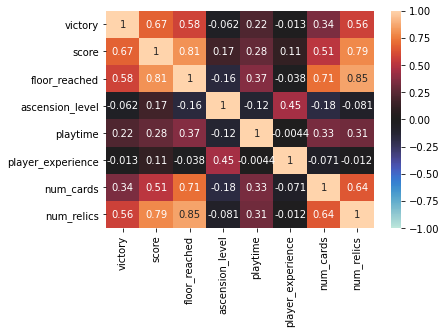

In [3]:
sns.heatmap(games.corr(), annot=True, vmin=-1, vmax=1, center=0);

Inicialmente foi analisada a matriz de correlação dos dataset, pelo fato de estarmos analisando partidas de um jogo, as correlações são bem intuitivas.

Um ponto interessante, é o fato de jogadores mais experientes estarem relacionados a dificuldades maiores, entretanto possuem correlação negativa com vitórias. Isso provavelmente se dá ao fato de jogadores mais experientes desistirem mais rápido de uma partida que seriam derrotas, isso também condiz com a relação negativa de andar alcançado (*floor reached*).

### Distribuição dos jogos por dificuldade

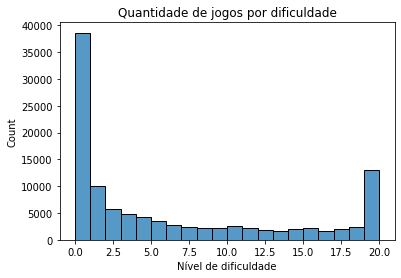

In [4]:
ax = sns.histplot(games.ascension_level, bins=range(21))
ax.set_title('Quantidade de jogos por dificuldade')
ax.set_xlabel('Nível de dificuldade');

Esse plot análise a distribuição dos jogos pelo nível de dificuldade, no caso temos que a maioria dos jogos estão nos extremos das dificuldades, isso ocorre, pois ao vencer o jogo em uma certa dificuldade a próxima é desbloqueada, o que desfavorece rejogabilidade das dificuldades intermediárias

Essa distribuição também indica que as análises de jogos com dificuldades intermediárias vão sofrer de um certo *bias*.

### Chance de vitoria por andar

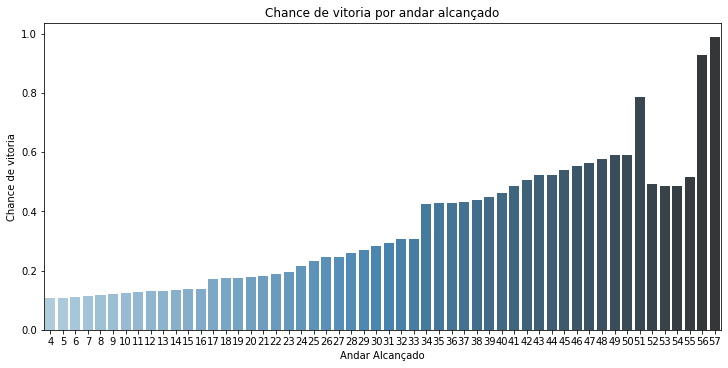

In [5]:
floor_win_rate = games.groupby('floor_reached').victory.agg(['count', 'sum']).sort_index(ascending=False).cumsum()
floor_win_rate = (floor_win_rate['sum'] / floor_win_rate['count']).sort_index()

fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(10, 5))
sns.barplot(x=floor_win_rate.index, y=floor_win_rate, palette='Blues_d', ax=ax)

ax.set_xlabel('Andar Alcançado')
ax.set_ylabel('Chance de vitoria')
ax.set_title('Chance de vitoria por andar alcançado');

Este gráfico mostra as chances de uma partida ser uma vitória dado que o jogador já alcançou um determinado andar. É interessante o aumento significativo nos andares 17, 34, 51, esse aumento ocorre, pois esses são andares que sucedem os boss de cada Ato, ou seja, se você derrotar um boss suas chances de ganhar aumentam significativamente.

Vale ressaltar também o vale que ocorre logo após o andar 51, no caso partidas normais são consideradas vitórias ao derrotar o boss final no andar 51, entretanto é possível, comprindo certas condições, enfretar o boss secreto, no andar 56 ou 57, ou seja, tentar derrotar esse nível bônus é significamente mais difícil do que apenas ganhar o jogo normalmente.

### Dano ao longo do jogo por dificuldade

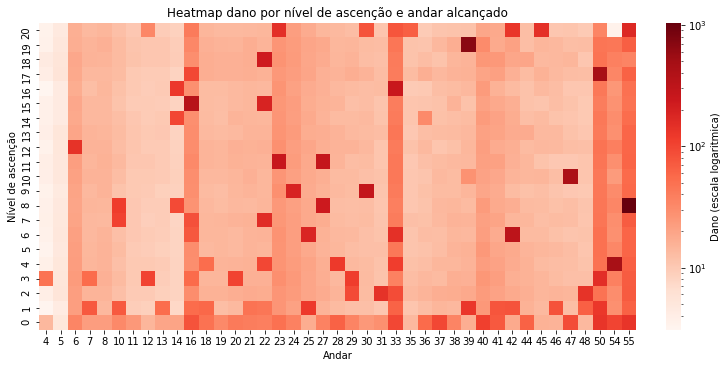

In [6]:
damage_heatmap = damage_taken.groupby(['ascension_level', 'floor']).damage.mean().unstack()
damage_heatmap = damage_heatmap.dropna(axis=1).sort_index(ascending=False)

fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(10, 5))

sns.heatmap(data=damage_heatmap, cmap='Reds', norm=LogNorm(), ax=ax);
ax.set_title('Heatmap dano por nível de ascenção e andar alcançado')
ax.set_xlabel('Andar')
ax.set_ylabel('Nível de ascenção')
ax.collections[0].colorbar.set_label('Dano (escala logaritmica)');

O heatmap mostra algumas aspectos interessantes das partidas as ao longo dos andares e dos níveis de dificuldade, o que eu achei mais impressionante é que apesar do nível de dificuldade o gradiente de dano na horizontal se mantém, o que significa a que o jogo fica mais difícil como um todo e não em partes específicas.

Além disso podemos ver precisamente o andar onde temos um boss, no caso as linhas verticais que formam meio que um fronteira entre as principais seções do jogo.

## Analise dos personagens
![characters](img/characters.png)
Em Slay the spire é possível selecionar entre 4 personagens, cada personagem possui cartas, relíquias e poderes exclusivos que modificam como o jogador interage com o jogo.

A escolha do personagem é interessante, pois é um das poucas decisões que não é influenciada pela regeneração randômica do jogo.

### Distribuição dos jogos por personagem

In [7]:
colors = sns.color_palette()

char_colors = {
    'IRONCLAD': colors[3],
    'THE_SILENT': colors[2],
    'DEFECT': colors[0],
    'WATCHER': colors[4]
}

plot_order = [
    'IRONCLAD',
    'THE_SILENT',
    'DEFECT',
    'WATCHER'
]

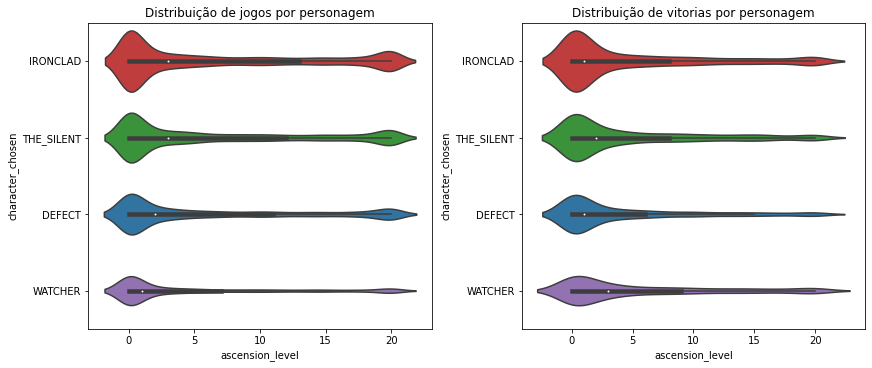

In [8]:
ascension_per_character = games[['character_chosen', 'ascension_level', 'victory']]
win_per_char = ascension_per_character[ascension_per_character.victory]

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 5))

sns.violinplot(y='character_chosen', x='ascension_level', data=ascension_per_character, scale='count', ax=axes[0], order=plot_order, palette=char_colors)
sns.violinplot(y='character_chosen', x='ascension_level', data=win_per_char, scale='count', ax=axes[1], order=plot_order, palette=char_colors)

axes[0].set_title('Distribuição de jogos por personagem');
axes[1].set_title('Distribuição de vitorias por personagem');    

Essa distribuição indica que o Ironclad é o personagem com mais jogos, esperado, visto que ele é o personagem que já vem liberado, o Watcher, por sua vez, é o personagem menos jogado, pois é o personagem mais recente e precisa ser desbloqueado.

Além disso, pela distribuição de vitórias, temos que apesar do Ironclad ser jogado em níveis de ascensão mais altos, ele também costuma perder nesse nível, visto que a média da distribuição de vitórias se encontra muito mais próximo de 0. Vale ressaltar, também, que esse comportamento se repete para os outros personagens, exceto o Watcher, isso provavelmente ocorre, por causa da reduzida quantidade de partidas e o fato do watcher só poder ser desbloqueado por jogadores mais experientes.

Por último, podemos perceber a óbvia tendência de quanto maior o nível de dificuldade menor a quantidade de vitórias de cada personagem.

### Chances de vitoria por personagem e dificuldade

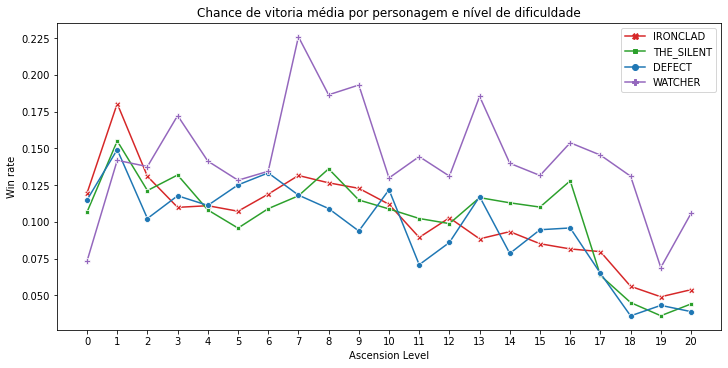

In [9]:
fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(10, 5))

win_rate_by_char = games.groupby(['ascension_level', 'character_chosen']).victory.mean().unstack()

sns.lineplot(data=win_rate_by_char, ax=ax, dashes=False, hue_order=plot_order, markers=True, palette=char_colors)

ax.set_title('Chance de vitoria média por personagem e nível de dificuldade')
ax.set_ylabel('Win rate')
ax.set_xlabel('Ascension Level')
ax.set_xticks(range(21))
ax.legend();

Apesar deste gráfico ser bem caótico, eu acredito que ele traz alguns insights interessantes sobre o comportamento do personagem conforme o jogador avança no jogo.

No caso, vemos que a chance de vitória do Watcher nos níveis 0 e 1 (onde temos mais observações) é bem mais baixo que os dos outros personagens, isso provavelmente indica um personagem difícil de entender, porém com condições de vitória bem frequentes, indicado pelos altos índices de vitória subsequentes.

Podemos analisar, também, a curva do Ironclad. Nesse caso, o personagem possui chances de vitória altos nos níveis iniciais(nível 1, principalmente), mas a dificuldade começa a afetar o personagem, principalmente após o nível 10. Isso provavelmente indica um personagem fácil de entender, mas difícil de masterizar.

### Quantidade de cartas no deck

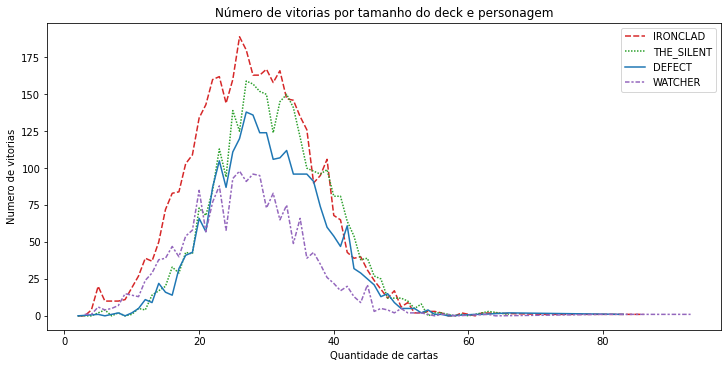

In [10]:
fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(10, 5))

win_rate_by_deck_length = games.groupby(['num_cards', 'character_chosen']).victory.sum().unstack()

sns.lineplot(data=win_rate_by_deck_length, ax=ax, hue_order=plot_order, palette=char_colors)

ax.set_title('Número de vitorias por tamanho do deck e personagem')
ax.set_ylabel('Numero de vitorias')
ax.set_xlabel('Quantidade de cartas')
ax.legend();

Pelo fato de Slay the spire ser um jogo de deckbuilding, é muito comum se encontrar no dilema entre adicionar um nova carta no deck para ganhar novas possibilidades ou remover cartas para aumentar a efetiva do deck, então surge a pergunta qual o tamanho ideal onde você tem efetividade e possibilidades?

No plot acima podemos ver que independente do personagem o deck ideal parece ter um tamanho entre 20 e 40 cartas, isso significa que para maximizar suas chances de vitória o ideal é tentar manter o deck dentro desses limites.

## Analise dos itens

### Quantidade média de cartas e reliquias por andar

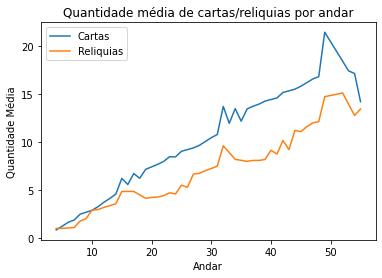

In [11]:
agg_cards_per_floor = cards.groupby('floor').num_cards.agg(['mean', 'count'])
agg_cards_per_floor = agg_cards_per_floor[agg_cards_per_floor['count'] > 200]

agg_relics_per_floor = relics.groupby('floor').num_relics.agg(['mean', 'count'])
agg_relics_per_floor = agg_relics_per_floor[agg_relics_per_floor['count'] > 200]

sns.lineplot(data=agg_cards_per_floor['mean'], label='Cartas');
sns.lineplot(data=agg_relics_per_floor['mean'], label='Reliquias');

plt.title('Quantidade média de cartas/reliquias por andar')
plt.xlabel('Andar')
plt.ylabel('Quantidade Média');

Nesse gráfico podemos perceber a tendência de acumular cartas e relíquias ao longo de jogo, é interessante notar também a queda na quantidade média de cartas nos últimos andares, essa queda provavelmente ocorre, por causa que a maioria dos jogos não chega ao final e os que chegam tem deques menores, porém com mais sinergia.

### Analise de frequência e efetividade das reliquias

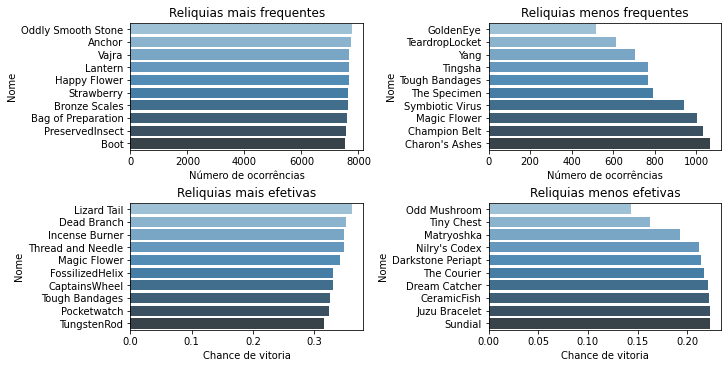

In [12]:
relics_runs_group_by = relics.groupby('relic').victory.agg(['mean', 'count'])

relics_runs_group_by = relics_runs_group_by[relics_runs_group_by['count'] > 500]

relics_frequency = relics_runs_group_by['count']
relics_win_rate = relics_runs_group_by['mean']

most_frequent = relics_frequency.nlargest(10)
least_frequent = relics_frequency.nsmallest(10)

high_win_rate = relics_win_rate.nlargest(10)
small_win_rate = relics_win_rate.nsmallest(10)

fig, axes = plt.subplots(2,2,constrained_layout=True, figsize=(10, 5))

sns.barplot(x=most_frequent, y=most_frequent.index, palette='Blues_d', ax=axes[0, 0]).set_title('Reliquias mais frequentes')
sns.barplot(x=least_frequent, y=least_frequent.index, palette='Blues_d', ax=axes[0, 1]).set_title('Reliquias menos frequentes')
sns.barplot(x=high_win_rate, y=high_win_rate.index, palette='Blues_d', ax=axes[1, 0]).set_title('Reliquias mais efetivas')
sns.barplot(x=small_win_rate, y=small_win_rate.index, palette='Blues_d', ax=axes[1, 1]).set_title('Reliquias menos efetivas')


# for i, ax in enumerate(axes):
for ax in axes[1]:
    ax.set_ylabel('Nome')
    ax.set_xlabel('Chance de vitoria')

for ax in axes[0]:
    ax.set_ylabel('Nome')
    ax.set_xlabel('Número de ocorrências')
    

Esses quatro gráficos são bem intuitivos, no caso eu esperava que o gráfico de relíquias mais efetivas e relíquias menos frequentes tivessem mais interações (apenas `magic flower` aparece nós dois), visto que elas seriam mais raras. Entretanto, vendo os gráficos, as relíquias menos não são apenas as mais raras, mas também as mais ignoradas, ou seja, se você tiver que escolher entre ela e outra relíquia você provavelmente escolhe a outra.

Outro fato interessante é que as relíquias menos efetivas tem efeitos que são fracos ou inúteis a curto prazo, mas que com tempo podem gerar um partida vencedora. `Matryoshka`, por exemplo, permite pegar duas relíquias por baú, entretanto baús são escassos e se o jogador não conseguir relíquias boas no baú ele acaba tendo um relíquia inútil. Contraste isso com `Lizard Tail` cujo efeito é simplesmente: se o jogador perder, ele renasce com uma certa porcentagem da vida.

## Conclusão

Meu objetivo com essa análise é mostrar que apesar de Slay the spire ser um jogo que depende em significamente de sorte, ainda existem diversas decisões táticas que influenciam o resultado de um partida de forma considerável.

No caso, vimos que uma estratégia interessante é acumular cartas no início do jogo para vencer os eventos iniciais e principalmente até o segundo boss (onde temos um aumento considerável em chances de vitória), a partir desse ponto seria recomendado manter seu deck no tamanho entre 30 e 40, visto que muitas cartas podem atrapalhar sinergias.

Além disso, é interessante ajustar suas expectativas, como vimos Watcher parace ter condições mais frequentes que os outros personagens, isso significa que se você estivar tendo um partida não muito boa, pode valer a pena continuar a jogando, visto que existem várias combinações que levam a vitória. Não é recomendada para o Ironclad, por exemplo, visto que as condições de vitória, principalmente, em dificuldades mais altas são mais escassas.

Do ponto de vista das relíquias vimos que é recomendado adquirir relíquias com efeitos relevantes a curto prazo, ao invés de relíquias com potenciais vantagens futuras.

### Considerações sobre o dataset

Eu acho que as análises poderiam ficar ainda melhores com dados específicos sobre relíquias e cartas, como raridade, exclusividade e efeitos. Esses dados podem ser obtidos, mas como eles não estavam presentes nos dataset original eu decidi por não adicionar essas informações.

O dataset também possui muitas outras informações ainda mais específicas sobre cada partida, mas como eu tive dificuldades em converter de json para csv, eu escolhi os atributos que pareciam mais pertinentes.

P.S: Esse notebook na verdade foi só uma desculpa para eu poder aproveitar as mais de 200 horas ~desperdiçadas~ investidas nesse jogo